### Install and Import

In [3]:
pip install tensorflow==2.11.0 opencv-python mediapipe scikit-learn matplotlib


  Using cached mediapipe-0.10.11-cp39-cp39-win_amd64.whl (50.8 MB)
  Using cached sounddevice-0.4.6-py3-none-win_amd64.whl (199 kB)
  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl (45.3 MB)
  Using cached jax-0.4.25-py3-none-any.whl (1.8 MB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\avani\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [1]:
import cv2
import numpy as np
import os
import time
from matplotlib import pyplot as plt
import mediapipe as mp
from datetime import datetime

### Drawing Keypoints on Video Feed

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
  while cap.isOpened(): #always

    ret, frame = cap.read()

    image, results = mediapipe_detection(frame, holistic)

    draw_styled_landmarks(image, results)

    cv2.imshow('OpenCV Feed', image)
    if cv2.waitKey(10) & 0xFF == ord('q'):
      break
  cap.release()
  cv2.destroyAllWindows()

In [7]:
len(results.face_landmarks.landmark)

468

In [8]:
draw_landmarks(frame, results)

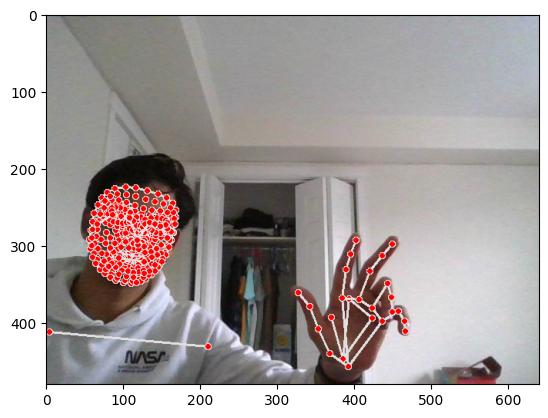

In [9]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

### Extracting Keypoints

In [10]:
len(results.pose_landmarks.landmark)

33

In [11]:
len(results.face_landmarks.landmark)

468

In [12]:
len(results.left_hand_landmarks.landmark)

21

In [13]:
len(results.right_hand_landmarks.landmark)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [14]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [15]:
extract_keypoints(results)[:5]

array([ 0.18511058,  0.61070377, -0.77894771,  0.99995983,  0.20984185])

### Folders for Image's NumPy Array Storage

In [44]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

In [45]:
for action in actions: 
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    # Folder start
    start_folder = dirmax
    print(dirmax)
    temp_strg=DATA_PATH+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(temp_strg, action, str(dirmax+sequence)))
        except:
            pass

59
59
59


In [17]:
# for action in actions: 
#     for sequence in range(no_sequences):
#         try: 
#             os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
#         except:
#             pass

### Collecting Keypoints for Training

In [46]:
def make_npy_array(action):

    cap = cv2.VideoCapture(0)
    # Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        
        # NEW LOOP
        # Loop through actions
        # for action in actions:
        # Loop through sequences aka videos
        for sequence in range(start_folder, start_folder+no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(temp_strg, action, str(sequence+1), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                        
        cap.release()
        cv2.destroyAllWindows()

In [51]:
# for hello
make_npy_array(actions[0])

In [52]:
# for thanks
make_npy_array(actions[1])

In [53]:
# for iloveyou
make_npy_array(actions[2])

### Preprocessing and EDA

In [54]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [55]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [56]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [57]:
np.array(sequences).shape

# (no_of_videos, no_of_frames_in_each_video, no_of_keypoints_in_each_frame)

(270, 30, 1662)

In [58]:
np.array(labels).shape

# (no_of_labels) same as number of videos

(270,)

In [59]:
X = np.array(sequences)

In [60]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1,

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [67]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(216, 30, 1662) (54, 30, 1662) (216, 3) (54, 3)


### Building the LSTM NN

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [69]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [70]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [71]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [72]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
7/7 [==============================] - 7s 92ms/step - loss: 1.7803 - categorical_accuracy: 0.3565
Epoch 2/2000
7/7 [==============================] - 1s 93ms/step - loss: 2.4512 - categorical_accuracy: 0.3148
Epoch 3/2000
7/7 [==============================] - 1s 96ms/step - loss: 1.1773 - categorical_accuracy: 0.3565
Epoch 4/2000
7/7 [==============================] - 1s 88ms/step - loss: 1.3257 - categorical_accuracy: 0.3009
Epoch 5/2000
7/7 [==============================] - 1s 87ms/step - loss: 1.2921 - categorical_accuracy: 0.3102
Epoch 6/2000
7/7 [==============================] - 1s 100ms/step - loss: 1.0938 - categorical_accuracy: 0.4028
Epoch 7/2000
7/7 [==============================] - 1s 90ms/step - loss: 0.8891 - categorical_accuracy: 0.5602
Epoch 8/2000
7/7 [==============================] - 1s 92ms/step - loss: 0.9185 - categorical_accuracy: 0.5926
Epoch 9/2000
7/7 [==============================] - 1s 91ms/step - loss: 0.5532 - categorical_accuracy: 0.7176


In [73]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 64)            442112    


                                                                 
 lstm_7 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-trainable params: 0
_________________________________________________________________


### Predictions

In [74]:
res = model.predict(X_test)
res

2/2 [==============================] - 1s 36ms/step


array([[7.43650459e-03, 8.13891292e-02, 9.11174357e-01],
       [9.23045933e-01, 1.38957435e-02, 6.30583614e-02],
       [1.78013171e-09, 9.91670489e-01, 8.32951721e-03],
       [1.12136889e-09, 9.92618501e-01, 7.38146110e-03],
       [5.63672483e-01, 1.99900810e-02, 4.16337371e-01],
       [2.36598244e-05, 6.68010354e-01, 3.31965983e-01],
       [6.13021298e-13, 9.98972297e-01, 1.02766941e-03],
       [5.14472227e-15, 9.99707758e-01, 2.92228593e-04],
       [3.57571594e-06, 9.38747168e-01, 6.12493008e-02],
       [9.04596686e-01, 1.64468437e-02, 7.89564773e-02],
       [9.60221708e-01, 9.45830811e-03, 3.03200074e-02],
       [8.89076944e-03, 1.94847230e-02, 9.71624553e-01],
       [1.04898913e-03, 7.36066103e-02, 9.25344408e-01],
       [3.61119539e-01, 1.83104463e-02, 6.20570004e-01],
       [4.83488711e-03, 6.10199869e-02, 9.34145093e-01],
       [3.07043232e-02, 7.30755031e-02, 8.96220148e-01],
       [5.05613745e-04, 5.63188568e-02, 9.43175554e-01],
       [9.32136714e-01, 1.34009

### Saving Weights

In [75]:
model.save('modelWeight.h5')

### Evaluation

In [76]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [77]:
yhat = model.predict(X_test)

2/2 [==============================] - 0s 28ms/step


In [78]:
ytrue = np.argmax(y_test, axis=1).tolist()
ytrue

[2,
 0,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 0,
 1,
 2,
 2,
 1,
 1,
 0]

In [79]:
yhat = np.argmax(yhat, axis=1).tolist()
yhat

[2,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 1,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 0,
 1,
 2,
 2,
 1,
 0,
 0]

In [80]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[34,  5],
        [ 0, 15]],

       [[33,  2],
        [ 1, 18]],

       [[34,  0],
        [ 6, 14]]], dtype=int64)

In [81]:
accuracy_score(ytrue, yhat)

0.8703703703703703

### Real-Time

In [82]:
from scipy import stats

In [83]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [84]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only length-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [85]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)
        
        # Draw landmarks
        # draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('SignLearn', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 191ms/step
hello
1/1 [==============================] - 0s 32ms/step
hello
1/1 [==============================] - 0s 34ms/step
hello
1/1 [==============================] - 0s 33ms/step
hello
1/1 [==============================] - 0s 51ms/step
hello
1/1 [==============================] - 0s 34ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 29ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 34ms/step
hello
1/1 [==============================] - 0s 34ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 33ms/step
hello
1/1 [==============================] - 0s 37ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 35ms/step
hello
1/1 [==============================] - 0s 29ms/step
hello
1/1 [========